# Business problem description:

## Xstation is a video game console company in the process of launching their own video game console soon. Before the company launches their console, they want to learn more about the strengths and weaknesses of their rival products(PlayStation 4 & Xbox One), so that Xstation can launch a competitive product.

## To learn more about the strengths and weaknesses of their rival products, a sentiment analysis will be conducted utilizing customer reviews of PlayStation 4 & Xbox One.

## Table of contents:

### 1. Import necessary packages & load datasets
### 2. Explore the datasets
### 3. Clean data
### 4. Plot word clouds
### 5. Update and edit the word clouds
**5.1 Insights from the word clouds**
###  6. Build a classifier for identifying positive and negative reviews
**6.1 Evaluation of the classifier & test scores**
### 7. Recommendations for Xstation based on the analysis

## 1. Import necessary packages & load datasets

In [ ]:
# Load necessary datasets
# Load the dataset with reviews from the server
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games.json.gz
# Load the dataset with metadata from the server
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Video_Games.json.gz

--2022-11-16 09:07:46--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 386419180 (369M) [application/x-gzip]
Saving to: ‘reviews_Video_Games.json.gz’

reviews_Video_Games 100%[===================>] 368.52M  9.74MB/s    in 84s     

2022-11-16 09:09:11 (4.37 MB/s) - ‘reviews_Video_Games.json.gz’ saved [386419180/386419180]

--2022-11-16 09:09:11--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Video_Games.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23557720 (22M) [application/x-gzip]
Saving to: ‘meta_Video_Games.json.gz’

meta_Video_Games.js 100%[===========

In [ ]:
# Import necessary libraries
import pandas as pd
import gzip
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from collections import Counter
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Functions to process file with reviews 
# Parse all the parts of the review file
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

# Read json to dictionary and turn it into the Data Frame
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [ ]:
# Fix the given products asin (Amazon Standard Identification Number)
asin_playstation = "B00BGA9WK2"
asin_xbox = "B00KAI3KW2"

In [ ]:
# Create DataFrame from JSON-file with reviews
df = getDF('reviews_Video_Games.json.gz')

In [ ]:
# Create DataFrame from JSON-file with meta data
df_meta = getDF('meta_Video_Games.json.gz')

In [ ]:
# See the meta description of the products
df_meta.loc[df_meta['asin'].isin([asin_playstation, asin_xbox])]

,asin,description,price,imUrl,related,salesRank,categories,title,brand
45933,B00BGA9WK2,,28.12,http://ecx.images-amazon.com/images/I/41omR-LT...,"{'also_bought': ['B00BGA9X9W', 'B00CXCCI8A', '...",{'Video Games': 13},"[[Electronics, Television & Video, Blu-ray Pla...",NaN,NaN
50837,B00KAI3KW2,,399.00,http://ecx.images-amazon.com/images/I/31BUxvm4...,"{'also_bought': ['B00CMQTUSS', 'B00FM5IY4W', '...",{'Video Games': 46},"[[Video Games, Xbox One, Consoles]]",NaN,NaN


In [ ]:
# Create product-related data frames 
df_playstation = df[df.asin.isin([asin_playstation])]
df_xbox = df[df.asin.isin([asin_xbox])]

## 2. Explore the datasets

In [ ]:
# Check the distribution of ratings for PlayStation 4
df_playstation['overall'].value_counts()

5.0    5123
1.0    1327
4.0     691
3.0     269
2.0     151
Name: overall, dtype: int64

In [ ]:
# Check the distribution of ratings for Xbox One
df_xbox['overall'].value_counts()

5.0    71
1.0    23
4.0    12
2.0     3
3.0     3
Name: overall, dtype: int64

In [ ]:
# For each product create new Data Frame and leave there only review text and rating
df_playstation_text = df_playstation[['reviewText','overall']].reset_index(drop=True)
df_xbox_text = df_xbox[['reviewText','overall']].reset_index(drop=True)

In [ ]:
# Create column "Sentiment" for sentiment values (0 - negative, 1 - positive). Sentiment is positive if "overall" rating value is >= 4.0
df_playstation_text["Sentiment"] = df_playstation_text['overall'].apply(lambda x: 1 if (x >=4.0) else 0)
df_xbox_text["Sentiment"] = df_xbox_text['overall'].apply(lambda x: 1 if (x >=4.0) else 0)

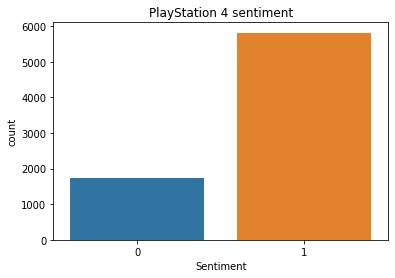

In [ ]:
# Plot sentiment for PlayStation 4
plt.figure(figsize = (6, 4))
sns.countplot(data = df_playstation_text, x = 'Sentiment')
plt.title("PlayStation 4 sentiment")
plt.show()

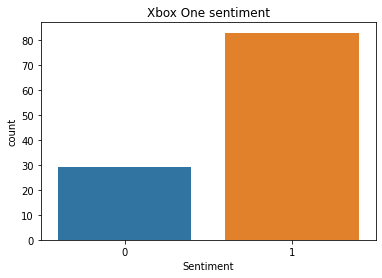

In [ ]:
# Plot sentiment for Xbox One
plt.figure(figsize = (6, 4))
sns.countplot(data = df_xbox_text, x = 'Sentiment')
plt.title("Xbox One sentiment")
plt.show()

## 3. Clean data

In [ ]:
# Create functions to clean the text
# Function to clean text
def clean_text(Review):   
  Review = str(Review).lower() # convert to lowercase
  Review = re.sub('\[.*?\]', '', Review)  # Remove special symbols
  Review = re.sub('https?://\S+|www\.\S+', '', Review) # Remove URls
  Review = re.sub('<.*?>+', '', Review) # Remove special symbols
  Review = re.sub(r'[^a-z0-9\s]', '', Review) # Remove punctuation
  Review = re.sub('\n', '', Review) # Remove forced enter
  Review = re.sub('\w*\d\w*', '', Review) # Remove metacharachters
  return Review
  
# Function to convert list to string 
def listToString(s):
   
  # initialize an empty string
  str1 = " "
  
  # return string 
  return (str1.join(s))

# Function to remove stopwords
def remove_stopword(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

In [ ]:
# Load standard list of stopwords
stop_words = stopwords.words('english')

In [ ]:
# Clean review texts for PlayStation 4
df_playstation_text['review'] = df_playstation_text['reviewText'].apply(clean_text)
df_playstation_text['review'] = df_playstation_text['review'].apply(lambda row: remove_stopword(stop_words, row)).apply(lambda row: listToString(row))

In [ ]:
# Clean review for Xbox One
df_xbox_text['review'] = df_xbox_text['reviewText'].apply(clean_text)
df_xbox_text['review'] = df_xbox_text['review'].apply(lambda row: remove_stopword(stop_words, row)).apply(lambda row: listToString(row))

In [ ]:
# Check how clean reviews look for PlayStation 4 or Xbox
df_xbox_text.head()

,reviewText,overall,Sentiment,review
0,Not everyone will use or need kinect in the be...,5.0,1,everyone use need kinect beginning get lower e...
1,I saw the xbox one in game shop it was amazing...,5.0,1,saw xbox one game shop amazing controller fit ...
2,the mic dont work well in game and some time w...,1.0,0,mic dont work well game time put controller co...
3,Xbox One is awesome.,5.0,1,xbox one awesome
4,It came quickly and works without a hitch. I c...,5.0,1,came quickly works without hitch cant wait get...


In [ ]:
# Create a Data Frame with negative reviews for PlayStation 4
df_playstation_neg = df_playstation_text[df_playstation_text.Sentiment == 0][["review"]].reset_index()

# Create a Data Frame with positive reviews for PlayStation 4
df_playstation_pos = df_playstation_text[df_playstation_text.Sentiment == 1][["review"]].reset_index()

In [ ]:
# Create a Data Frame with negative reviews for Xbox One
df_xbox_neg = df_xbox_text[df_xbox_text.Sentiment == 0][["review"]].reset_index()

# Create a Data Frame with positive reviews for Xbox One
df_xbox_pos = df_xbox_text[df_xbox_text.Sentiment == 1][["review"]].reset_index()

## 4. Plot word clouds

In [ ]:
# Create function, that creates string for a word cloud
def create_string(col):
  string = ''
  for val in col:
    list = nltk.word_tokenize(val)
    for m in list:
      string += " " + m
  return string

In [ ]:
# Create string for a word cloud for negative reviews for PlayStation 4
string_playstation_neg = create_string(df_playstation_neg["review"])

# Create string for a word cloud for positive reviews for PlayStation 4
string_playstation_pos = create_string(df_playstation_pos["review"])

# Create string for a word cloud for negative reviews for Xbox One
string_xbox_neg = create_string(df_xbox_neg["review"])

# Create string for a word cloud for positive reviews for Xbox One
string_xbox_pos = create_string(df_xbox_pos["review"])

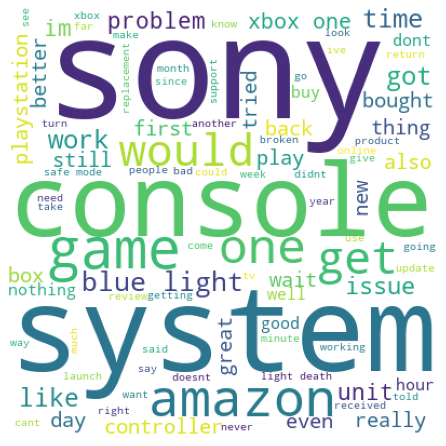

In [ ]:
# Create wordcloud for negative reviews for PlayStation 4
wordcloud_playstation_neg = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(string_playstation_neg)

# Plot the wordcloud
plt.figure(figsize = (6, 6), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud_playstation_neg) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

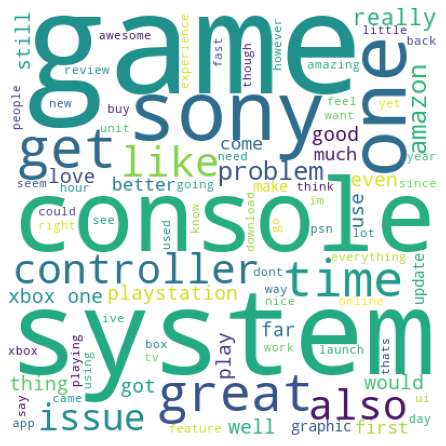

In [ ]:
# Create wordcloud for positive reviews for PlayStation 4
wordcloud_playstation_pos = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(string_playstation_pos)

# Plot the wordcloud
# DO NOT MODIFY THE CODE
plt.figure(figsize = (6, 6), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud_playstation_pos) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

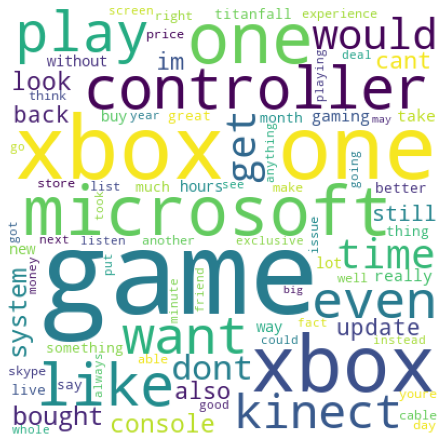

In [ ]:
# Create wordcloud for negative reviews for Xbox One
# wordcloud_xbox_neg = WordCloud(...).generate(...)

wordcloud_xbox_neg = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(string_xbox_neg)

# Plot the wordcloud
# DO NOT MODIFY THE CODE
plt.figure(figsize = (6, 6), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud_xbox_neg) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

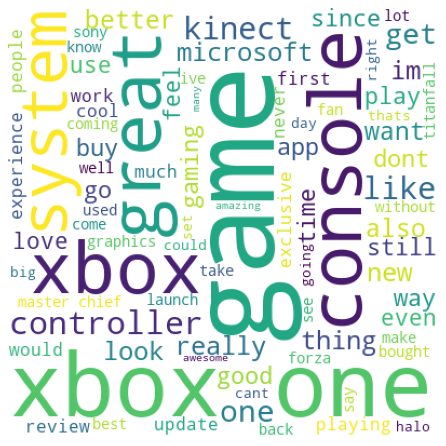

In [ ]:
# Create wordcloud for positive reviews for Xbox One
# wordcloud_xbox_pos = WordCloud(...).generate(...)

wordcloud_xbox_pos = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(string_xbox_pos)

# Plot the wordcloud
# DO NOT MODIFY THE CODE
plt.figure(figsize = (6, 6), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud_xbox_pos) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## 5. Update and edit the word clouds

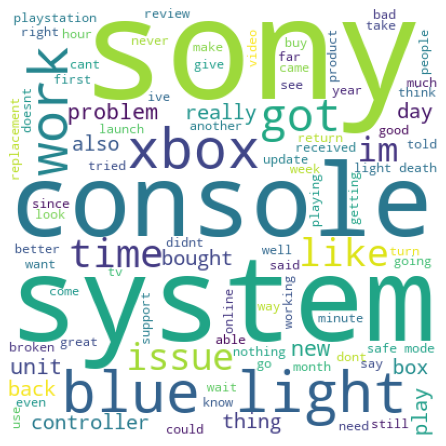

In [ ]:
# Update stop words if necessary and build new word clouds
# Update the playstation neg cloud

stopwords_playstation_neg = ['would', 'get', 'one', 'game', 'games', 'amazon']
df_playstation_neg['review'] = df_playstation_neg['review'].apply(lambda row: remove_stopword(stopwords_playstation_neg, row)).apply(lambda row: listToString(row))

string_neg_1 = create_string(df_playstation_neg["review"])

wordcloud_neg_1 = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(string_neg_1)

plt.figure(figsize = (6, 6), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud_neg_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

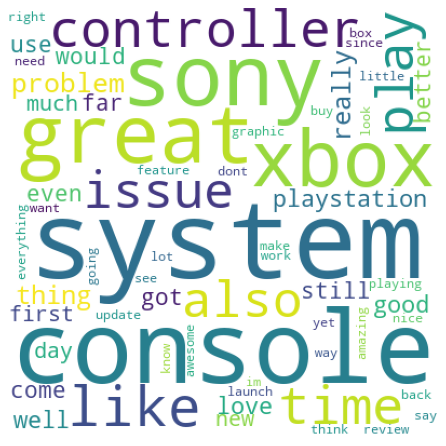

In [ ]:
# Update stop words if necessary and build new word clouds
# Update the playstation pos cloud

stopwords_playstation_pos = ['get','game', 'games', 'one', 'amazon']
df_playstation_pos['review'] = df_playstation_pos['review'].apply(lambda row: remove_stopword(stopwords_playstation_pos, row)).apply(lambda row: listToString(row))

string_pos_1 = create_string(df_playstation_pos["review"])

wordcloud_pos_1 = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(string_pos_1)

plt.figure(figsize = (6, 6), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud_pos_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

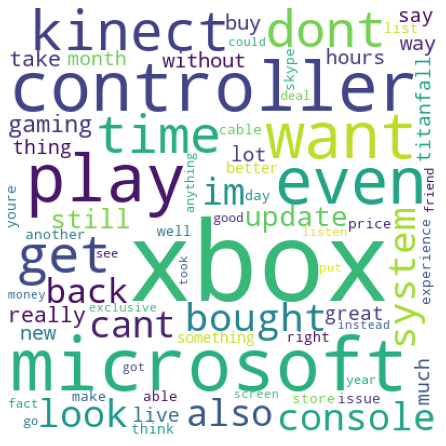

In [ ]:
# Update stop words if necessary and build new word clouds
# Update the xbox neg cloud

stopwords_xbox_neg = ['game','like','games', 'would', 'one']
df_xbox_neg['review'] = df_xbox_neg['review'].apply(lambda row: remove_stopword(stopwords_xbox_neg, row)).apply(lambda row: listToString(row))

string_neg_2 = create_string(df_xbox_neg["review"])

wordcloud_neg_2 = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(string_neg_2)

plt.figure(figsize = (6, 6), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud_neg_2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

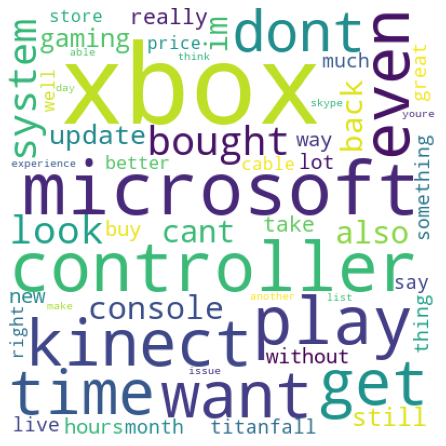

In [ ]:
# Update stop words if necessary and build new word clouds
# Update the xbox pos cloud

stopwords_xbox_pos = ['game','get','look','like', 'one']
df_xbox_pos['review'] = df_xbox_pos['review'].apply(lambda row: remove_stopword(stopwords_xbox_pos, row)).apply(lambda row: listToString(row))

string_pos_2 = create_string(df_xbox_pos["review"])

wordcloud_pos_2 = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(string_neg_2)

plt.figure(figsize = (6, 6), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud_pos_2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### 5.1 Insights from the word clouds

#### Positive reviews:

In the case of positive reviews seen from the Xbox and Playstation positive word clouds, the words **controller, system, play, Sony, Microsoft, and Xbox**. From these words, it would seem that gamers place emphasis on the system of the console, gameplay and how it feels, as well as controller used for the console. Additionally, there is also the brand value and loyalty aspect where gamers care about the maker of the console, and how the actual console is perceived amongst others. 

#### Negative reviews:

Similar to positive word clouds, the words **controller, system, play, Xbox, and Microsoft** can also be seen in Xbox's negative word cloud. This could potentially suggest that although some gamers like the Xbox and its features, there are some gamers that have a dislike for it. In other words, it is a matter of taste. Additionally, some gamers might have a dislike for Microsoft as a company which might explain why the company's name is present in the cloud.

Moreover, in the case of Playstation's positive word cloud, the words Sony, console, blue light, and system can be seen. Just with Xbox some gamers might like the Playstation and its features, whereas some other gamers might not. In addition to this, just like with Xbox also, some gamers might have a dislike for Sony as a company which might explain why the company's name is present in the cloud. Lastly, the blue light in Playstation is associated with an error in the console, ruining the gaming experince for gamers.   



## 6. Build a classifier for identifying positive and negative reviews

In [ ]:
# Create vectors for features and labels for PlayStation 4
X_playstation = df_playstation_text['review']
y_playstation = df_playstation_text['Sentiment']

In [ ]:
# Create vectors for features and labels for Xbox One
X_xbox = df_xbox_text['review']
y_xbox = df_xbox_text['Sentiment']

In [ ]:
# Build a model for PlayStation 4 reviews
# Make a train-test split for PlayStation 4
X_playstation_train, X_playstation_test, y_playstation_train, y_playstation_test = train_test_split(X_playstation, y_playstation, random_state = 42, test_size = 0.20)

In [ ]:
# Build a model for Xbox One reviews
# Make a train-test split for Xbox One 
X_xbox_train, X_xbox_test, y_xbox_train, y_xbox_test = train_test_split(X_xbox, y_xbox, random_state = 42, test_size = 0.20)

In [ ]:
# Create vectors for features and labels for PlayStation 4
X_playstation = df_playstation_text['review']
y_playstation = df_playstation_text['Sentiment']

In [ ]:
# Create vectors for features and labels for Xbox One
X_xbox = df_xbox_text['review']
y_xbox = df_xbox_text['Sentiment']

In [ ]:
# Make a train-test split for PlayStation 4
X_playstation_train, X_playstation_test, y_playstation_train, y_playstation_test = train_test_split(X_playstation, y_playstation, random_state = 42, test_size = 0.20)

In [ ]:
# Make a train-test split for Xbox One 
X_xbox_train, X_xbox_test, y_xbox_train, y_xbox_test = train_test_split(X_xbox, y_xbox, random_state = 42, test_size = 0.20)

Test accuracy: 0.806
Precision: 0.800
Recall: 0.997
F1 Score: 0.887


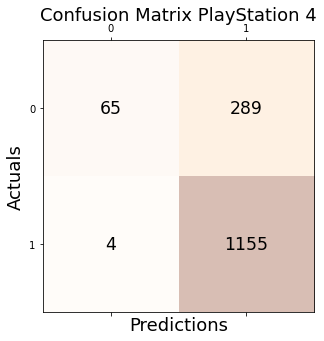

In [ ]:
# Create a pipeline to run a Naive Bayes Classifier for PlayStation 4
clf_playstation = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())])

# Fit train data to the model for PlayStation 4
clf_playstation.fit(X_playstation_train, y_playstation_train)

# Predict results on test data for PlayStation 4
y_playstation_pred = clf_playstation.predict(X_playstation_test)

# Print model metrics for PlayStation 4
print('Test accuracy: %.3f' % accuracy_score(y_playstation_test, y_playstation_pred))
print('Precision: %.3f' % precision_score(y_playstation_test, y_playstation_pred))
print('Recall: %.3f' % recall_score(y_playstation_test, y_playstation_pred))
print('F1 Score: %.3f' % f1_score(y_playstation_test, y_playstation_pred))

# Create a confusion matrix for PlayStation 4 and print it
conf_matrix_playstation = confusion_matrix(y_true=y_playstation_test, y_pred=y_playstation_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_playstation, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_playstation.shape[0]):
    for j in range(conf_matrix_playstation.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_playstation[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix PlayStation 4', fontsize=18)
plt.show()

Test accuracy: 0.826
Precision: 0.826
Recall: 1.000
F1 Score: 0.905


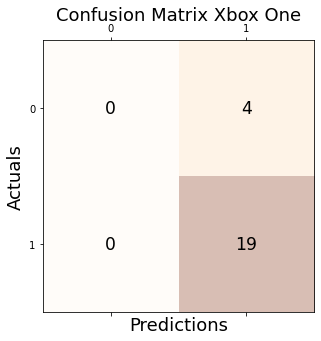

In [ ]:
# Create a pipeline to run a Naive Bayes Classifier for Xbox One
clf_xbox = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())])

# Fit train data to the model for Xbox One
clf_xbox.fit(X_xbox_train, y_xbox_train)

# Predict results on test data for Xbox One
y_xbox_pred = clf_xbox.predict(X_xbox_test)

# Print model metrics for Xbox One
print('Test accuracy: %.3f' % accuracy_score(y_xbox_test, y_xbox_pred))
print('Precision: %.3f' % precision_score(y_xbox_test, y_xbox_pred))
print('Recall: %.3f' % recall_score(y_xbox_test, y_xbox_pred))
print('F1 Score: %.3f' % f1_score(y_xbox_test, y_xbox_pred))

# Create a confusion matrix for Xbox One and print it
conf_matrix_xbox = confusion_matrix(y_true=y_xbox_test, y_pred=y_xbox_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix_xbox, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix_xbox.shape[0]):
    for j in range(conf_matrix_xbox.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix_xbox[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix Xbox One', fontsize=18)
plt.show()


### 6.1 Evaluation of the classifier & test scores

#### Xbox confusion matrix:

The model is able to 100% correctly identify actual positive reviews. On the other hand, the model faces issue with classifying truly negative reviews. It identifies all of the true negative reviews as positive, even though they are not. However, the test size for the xbox is very small which is something to be kept in mind.

#### Playstation confusion matrix:

The model does almost perfectly well when it comes to classifying truly positive reviews. On the other hand, just like with the case of Xbox, the model is slightly struggling when it comes to identifying truly negative reviews. There are some cases where the model predicts them as positive, even though are actually negative.

#### test scores:

In this instance, it appears that the model for the xbox appears to be performing better than the playstation one across all of the four metrics (**Test accuracy, Precision, Recall & F1 Score**). Overall, both of the models perform well across of all the four metrics, and the difference between their scores are marginal. However, it should be noted that the overall sample size, and therefore also the test size for the Xbox data is significantly much smaller than than the playstation one, which might have an impact and explain the marginal difference in these scores.  


## 7. Recommendations for Xstation based on the analysis

### -Xstation should place an emphasis on gameplay(its feel and experience) and producing a nice controller for their gaming console

### -The company should also perhaps invite gaming enthusiasts to try their product before it is launched to get valuable insights from them, as well as improve their console

### -It is worth mentioning also that Xstation should not try to please every gamer out there since what is to one's liking might not be to someone else